In [49]:
import time
from pennylane import numpy as np
import torch
import matplotlib.pyplot as plt
import pennylane as qml


In [50]:
def prepare_molecule(bond_dist):
    """
    Function to initialize the molecule and return the hamiltonian and qubits.
    """
    symbols = ["H", "H"]
    geometry = np.array([[0., 0., -bond_dist/2], [0., 0., bond_dist/2]])  # Coordinates in Bohr
    molecule = qml.qchem.Molecule(symbols, geometry)
    hamiltonian, qubits = qml.qchem.molecular_hamiltonian(molecule)
    
    return hamiltonian, qubits

def advanced_ansatz(params):
    """
    Function to define the advanced quantum circuit ansatz using single excitations.
    """
    hf_state = np.array([1, 1, 0, 0])  # Hartree-Fock state
    # Prepare the Hartree-Fock state
    qml.BasisState(hf_state, wires=[0, 1, 2, 3])
    # Define single excitations
    qml.SingleExcitation(params[0], wires=[0, 2])
    qml.SingleExcitation(params[1], wires=[1, 3])
    qml.SingleExcitation(params[2], wires=[0, 3])
    qml.SingleExcitation(params[3], wires=[1, 2])

def plot_convergence(costs):
    """
    Function to plot the energy convergence during optimization.
    """
    plt.plot(range(len(costs)), costs, '-o', label="Energy", markersize=3)
    plt.xlabel('Iteration')
    plt.ylabel('Energy (Hartree)')
    plt.title('Energy Convergence with UCCS-like Ansatz for H2')
    plt.legend()
    plt.grid(True)
    plt.show()

In [51]:
def create_qnode_torch(hamiltonian, qubits):
    """
    Function to create a QNode that computes the expectation value of the Hamiltonian.
    """
    dev = qml.device('default.qubit', wires=qubits)    

    @qml.qnode(dev,interface='torch')
    def circuit(params):
        advanced_ansatz(params)
        return qml.expval(hamiltonian)
    
    return circuit


def torch_optimize(qnode, init_params, step_num, optimizer_class, lr, patience=50, verbose=False):
    """
    Function to perform optimization using torch and the given optimizer, with added patience for convergence.
    """
    params = torch.from_numpy(np.copy(init_params)).float()
    params.requires_grad = True

    optimizer = optimizer_class(params=[params], lr=lr)  # Initialize optimizer with the given parameters
    costs = []
    times = []
    prev_cost = float("-inf")
    conv_tol = 1e-06
    patience_counter = 0

    for i in range(step_num):
        # Define the closure for L-BFGS optimizer
        start_time = time.time()
        
        def closure():
            optimizer.zero_grad()
            cost = qnode(params)
            if cost.requires_grad:
                cost.backward()
            return cost.detach().numpy()

        # Perform optimization step
        cost = optimizer.step(closure)
        costs.append(cost)
        
        # Check for convergence with patience
        conv = np.abs(cost - prev_cost)
        if conv <= conv_tol:
            patience_counter += 1
            if patience_counter >= patience:
                break
        else:
            patience_counter = 0  # Reset patience if cost changes significantly
        
        prev_cost = cost
        times.append(time.time() - start_time)
        
        if verbose and (i + 1) % 100 == 0:
            print(f"Cost after step {i + 1}: {costs[-1]}")
    
    return costs, times, i


def optimizer_run_pytorch(opt, step_num, bond_dist, lr, verbose=True):
    """
    Main function that prepares the molecule, initializes the QNode,
    runs optimization, and plots the results.
    """
    # Prepare the molecule and hamiltonian
    hamiltonian, qubits = prepare_molecule(bond_dist)
    
    # Create QNode
    qnode = create_qnode_torch(hamiltonian, qubits)

    # Initialize parameters and run optimization
    init_params = np.random.normal(0, np.pi, 4)
    costs, times, steps = torch_optimize(qnode, init_params, step_num, opt, lr, verbose=verbose)
    if (verbose):
        # Plot the energy convergence
        plot_convergence(costs)
    
    return costs, times, steps



In [52]:
def create_qnode(hamiltonian, qubits):
    """
    Function to create a QNode that computes the expectation value of the Hamiltonian.
    """
    dev = qml.device('default.qubit', wires=qubits)    
    @qml.qnode(dev)  # Use default NumPy interface
    def circuit(params):
        advanced_ansatz(params)
        return qml.expval(hamiltonian)
    return circuit

def pennylane_optimize(qnode, init_params, step_num, opt_class, stepsize, patience=50, verbose=False):
    """
    Function to perform optimization using PennyLane's optimizers with a patience mechanism for convergence.
    """
    params = np.copy(init_params)  # Use NumPy array for parameters
    opt = opt_class(stepsize=stepsize)  # Instantiate the PennyLane optimizer
    costs = []
    times = []
    prev_cost = float('inf')
    conv_tol = 1e-6
    patience_counter = 0

    for i in range(step_num):
        start_time = time.time()
        new_params, cost = opt.step_and_cost(qnode, params)  # Perform one optimization step
        params = new_params
        costs.append(cost)
        times.append(time.time() - start_time)
        
        # Check for convergence
        conv = np.abs(cost - prev_cost)
        if conv <= conv_tol:
            patience_counter += 1
            if patience_counter >= patience:
                if verbose:
                    print(f"Converged after {i + 1} steps with cost: {cost}")
                break
        else:
            patience_counter = 0
        prev_cost = cost
        
        if verbose and (i + 1) % 100 == 0:
            print(f"Cost after step {i + 1}: {cost}")
    
    return costs, times, i


def optimizer_run(opt_class, step_num, bond_dist, stepsize, verbose=True):
    """
    Main function that prepares the molecule, initializes the QNode,
    runs optimization, and plots the results.
    """
    # Prepare the molecule and hamiltonian
    hamiltonian, qubits = prepare_molecule(bond_dist)
    
    # Create QNode
    qnode = create_qnode(hamiltonian, qubits)

    # Initialize parameters and run optimization
    init_params = np.random.normal(0, np.pi, 4)
    costs, times, steps = pennylane_optimize(qnode, init_params, step_num, opt_class, stepsize, patience=50, verbose=verbose)
    
    if verbose:
        # Plot the energy convergence
        plot_convergence(costs)
    
    return costs, times, steps


Cost after step 100: -1.1152063691191167
Converged after 123 steps with cost: -1.115206460177836


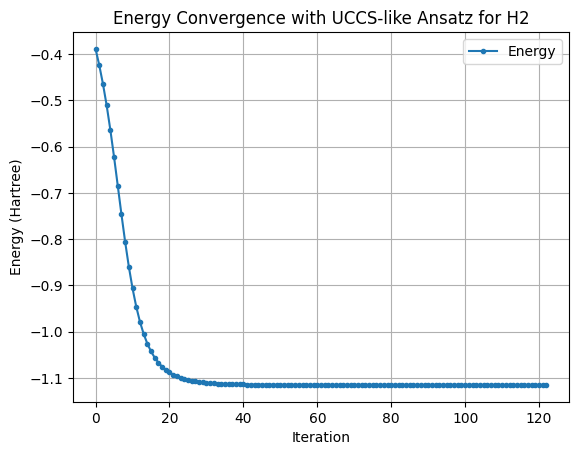

In [53]:
costs, times, steps = optimizer_run(qml.GradientDescentOptimizer, step_num=10000, bond_dist = 0.72*2, stepsize=0.4, verbose=True)

/home/somay/.local/lib/python3.10/site-packages/pennylane/math/interface_utils.py:127: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow, PyTorch, and Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/pennylane/math/interface_utils.py:127: UserWarning: Contains tensors of types {'torch', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


Cost after step 100: -0.8805300206890765
Cost after step 200: -1.1162491011532496
Cost after step 300: -1.1173392948113903


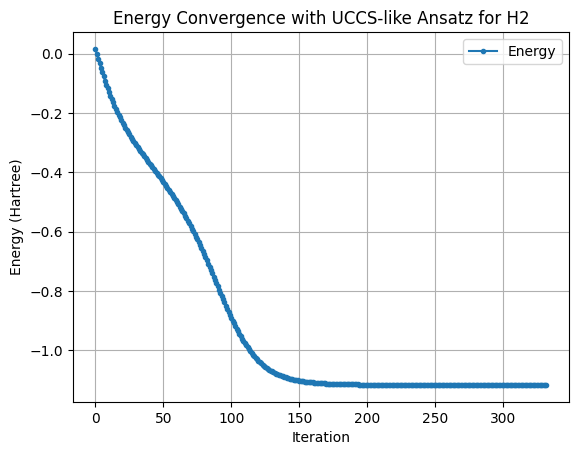

-1.1173469810233114 332


In [54]:
costs, times, steps = optimizer_run_pytorch(torch.optim.SGD, step_num=10000, bond_dist = 1.32280828, lr = 1e-1,  verbose=True)
print(costs[-1],steps)

In [55]:
def energy_vs_bondLength(optimzer):
    # Define a range of bond lengths (in Bohr, 1 Bohr = 0.529 Å)
    bond_lengths = np.linspace(0.5, 3.0, 30)  # From 0.5 to 3.0 Bohr

    # Lists to store results
    final_energies = []
    convergence_iterations = []

    # Loop over bond lengths
    for bond_length in bond_lengths:
        
        costs, times, steps = optimizer_run(optimzer, step_num = 10000, bond_dist = bond_length, stepsize= 0.4,  verbose=False)
        # Store results
        final_energies.append(costs[-1])
        convergence_iterations.append(steps + 1)
        print(f"Bond length: {bond_length:.2f} Bohr, Energy: {costs[-1]:.6f} Ha, Iterations: {steps + 1}")

    # Create two subplots
    plt.figure(figsize=(12, 5))

    # Plot 1: Energy vs. Bond Length (Potential Energy Curve)
    plt.subplot(1, 2, 1)
    plt.plot(bond_lengths, final_energies, 'o-', label="Ground State Energy")
    plt.xlabel('Bond Length (Bohr)')
    plt.ylabel('Energy (Hartree)')
    plt.title('Potential Energy Curve of H2')
    plt.legend()
    plt.grid(True)

Bond length: 0.50 Bohr, Energy: -0.403326 Ha, Iterations: 99
Bond length: 0.59 Bohr, Energy: -0.638573 Ha, Iterations: 74
Bond length: 0.67 Bohr, Energy: -0.797588 Ha, Iterations: 74
Bond length: 0.76 Bohr, Energy: -0.907257 Ha, Iterations: 102
Bond length: 0.84 Bohr, Energy: -0.983494 Ha, Iterations: 84
Bond length: 0.93 Bohr, Energy: -1.036249 Ha, Iterations: 103
Bond length: 1.02 Bohr, Energy: -1.072035 Ha, Iterations: 113
Bond length: 1.10 Bohr, Energy: -1.095297 Ha, Iterations: 86
Bond length: 1.19 Bohr, Energy: -1.109182 Ha, Iterations: 100
Bond length: 1.28 Bohr, Energy: -1.115989 Ha, Iterations: 108
Bond length: 1.36 Bohr, Energy: -1.117432 Ha, Iterations: 98
Bond length: 1.45 Bohr, Energy: -1.114807 Ha, Iterations: 122
Bond length: 1.53 Bohr, Energy: -1.109090 Ha, Iterations: 143
Bond length: 1.62 Bohr, Energy: -1.101023 Ha, Iterations: 157
Bond length: 1.71 Bohr, Energy: -1.091161 Ha, Iterations: 180
Bond length: 1.79 Bohr, Energy: -1.079929 Ha, Iterations: 188
Bond length: 1

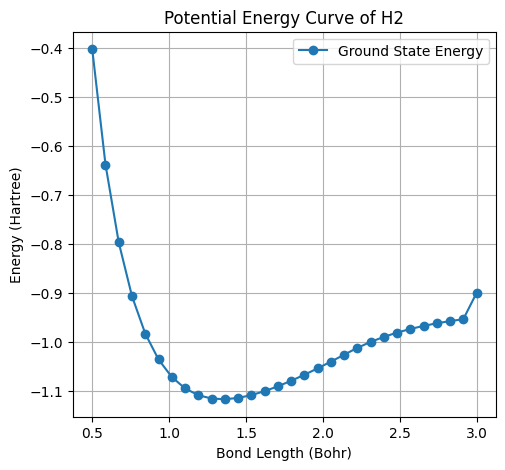

In [56]:
energy_vs_bondLength(qml.GradientDescentOptimizer)